# Задача о Маятнике

Наша цель обучить несколько моделей для этой [задачи](https://gymnasium.farama.org/environments/classic_control/pendulum/):

## Подготовка данных

In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)

In [ ]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

In [ ]:
env.reset(seed=123, options={"low": -0.7, "high": 0.5})

(array([ 0.4123625 ,  0.91101986, -0.89235795], dtype=float32), {})

In [ ]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Обучение с подкреплением на основе DQN (предсказываю положение через н секунд)

### Обучение (n=5, дискретных действий = 21)

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Создаем среду
env = gym.make('Pendulum-v1', render_mode=None)

# Настройки
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
LR = 0.0005
TARGET_UPDATE = 10
MEMORY_SIZE = 20000
HIDDEN_SIZE = 128
N_FUTURE_STEPS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        hidden_representation = F.relu(self.fc2(x))
        hidden_representation = self.dropout(hidden_representation)
        return self.fc3(hidden_representation), hidden_representation

    def get_hidden_representation(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))

class SecondaryNetwork(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SecondaryNetwork, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

def discretize_action(action_idx, action_size):
    action_range = np.linspace(-2.0, 2.0, action_size)
    return np.array([action_range[action_idx]])

def select_action(state, policy_net, action_size, epsilon):
    if random.random() < epsilon:
        return torch.tensor([[random.randrange(action_size)]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            q_values, _ = policy_net(state)
            return q_values.max(1)[1].view(1, 1)

def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: not s, batch.done)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    q_values, _ = policy_net(state_batch)
    state_action_values = q_values.gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_q_values, _ = target_net(non_final_next_states)
        next_state_values[non_final_mask] = next_q_values.max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.item()

state_size = 3
action_size = 21
num_episodes = 1000

policy_net = DQN(state_size, action_size, HIDDEN_SIZE).to(device)
target_net = DQN(state_size, action_size, HIDDEN_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

episode_rewards = []
losses = []
epsilon = EPS_START

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    total_reward = 0
    episode_loss = 0
    steps = 0
    done = False
    truncated = False

    while not (done or truncated):
        action_idx = select_action(state, policy_net, action_size, epsilon)
        action = discretize_action(action_idx.item(), action_size)
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
        done_tensor = torch.tensor([done or truncated], device=device, dtype=torch.bool)

        memory.push(state, action_idx, next_state, reward, done_tensor)
        state = next_state

        loss = optimize_model(memory, policy_net, target_net, optimizer)
        if loss > 0:
            episode_loss += loss
            steps += 1

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    episode_rewards.append(total_reward)
    losses.append(episode_loss / steps if steps > 0 else 0)

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Эпизод {episode}/{num_episodes}, Средняя награда: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")

# Сбор данных для вторичной сети
print("Сбор данных для обучения вторичной сети...")
X_train = []
y_train = []

policy_net.eval()
num_collect_episodes = 100

for episode in range(num_collect_episodes):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    episode_states = []
    hidden_reps = []
    done = False
    truncated = False

    while not (done or truncated):
        with torch.no_grad():
            q_values, hidden_rep = policy_net(state)
            action_idx = q_values.max(1)[1].view(1, 1)

        hidden_reps.append(hidden_rep.cpu().numpy())
        episode_states.append(state.cpu().numpy())

        action = discretize_action(action_idx.item(), action_size)
        next_state, _, done, truncated, _ = env.step(action)
        state = torch.tensor([next_state], device=device, dtype=torch.float32)

    for i in range(len(episode_states) - N_FUTURE_STEPS):
        X_train.append(hidden_reps[i])
        y_train.append(episode_states[i + N_FUTURE_STEPS][0])

X_train = np.vstack(X_train)
y_train = np.array(y_train)

print(f"Собрано {len(X_train)} примеров для обучения")

# Нормализация выходов
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Обучение вторичной сети
print("Обучение вторичной сети...")
secondary_net = SecondaryNetwork(HIDDEN_SIZE, state_size).to(device)
secondary_optimizer = optim.Adam(secondary_net.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

X_tensor = torch.tensor(X_train, device=device, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, device=device, dtype=torch.float32)

secondary_epochs = 200
batch_size = 32
n_samples = len(X_tensor)

secondary_losses = []
for epoch in range(secondary_epochs):
    indices = torch.randperm(n_samples)
    epoch_loss = 0

    for i in range(0, n_samples, batch_size):
        batch_idx = indices[i:i+batch_size]
        batch_X = X_tensor[batch_idx]
        batch_y = y_tensor[batch_idx]

        predictions = secondary_net(batch_X)
        loss = criterion(predictions, batch_y)

        secondary_optimizer.zero_grad()
        loss.backward()
        secondary_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (n_samples // batch_size)
    secondary_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Эпоха {epoch}/{secondary_epochs}, Loss: {avg_loss:.4f}")

Используется устройство: cuda


KeyboardInterrupt: 

### Метрики

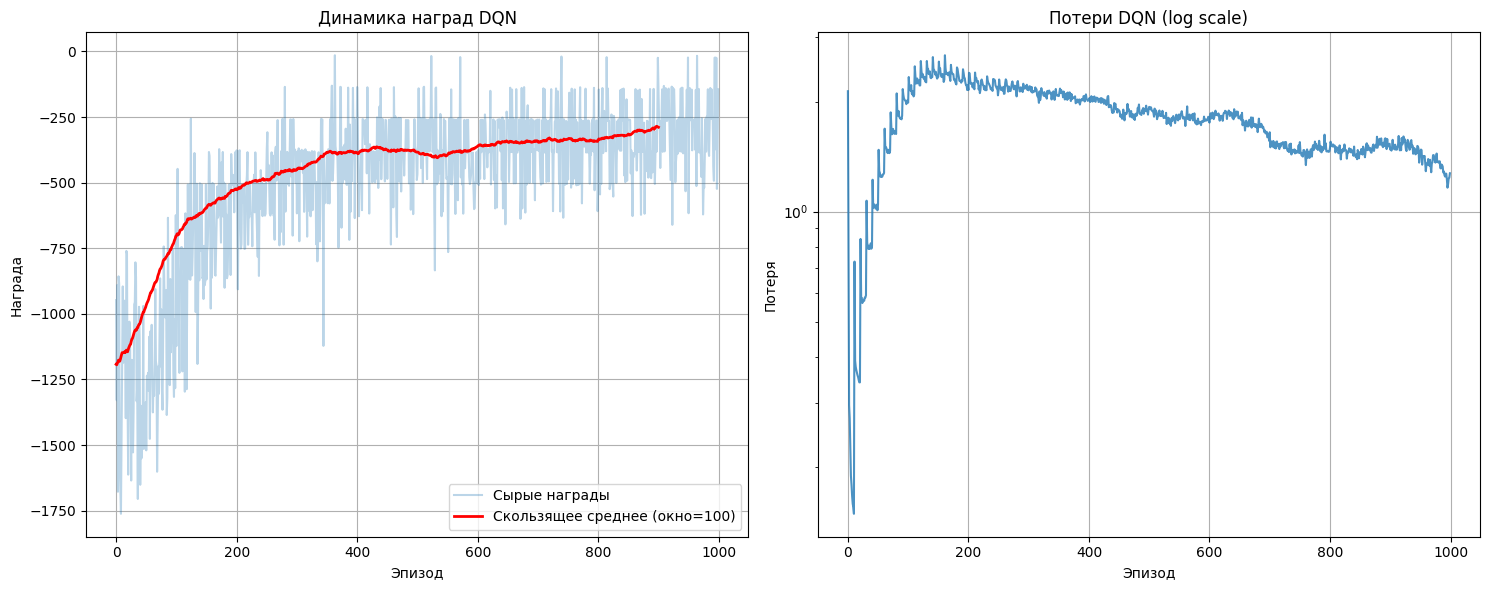

In [ ]:
# Вместо текущих графиков обучения DQN
plt.figure(figsize=(15, 6))

# График наград с усреднением
plt.subplot(1, 2, 1)
window_size = max(1, len(episode_rewards)//10)
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(episode_rewards, alpha=0.3, label='Сырые награды')
plt.plot(smoothed_rewards, color='red', linewidth=2, label=f'Скользящее среднее (окно={window_size})')
plt.title('Динамика наград DQN')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True)

# График потерь с логарифмической шкалой
plt.subplot(1, 2, 2)
plt.plot(losses, alpha=0.8)
plt.yscale('log')  # Логарифмическая шкала для лучшей читаемости
plt.title('Потери DQN (log scale)')
plt.xlabel('Эпизод')
plt.ylabel('Потеря')
plt.grid(True)

plt.tight_layout()
plt.savefig('improved_dqn_training.png')
plt.show()

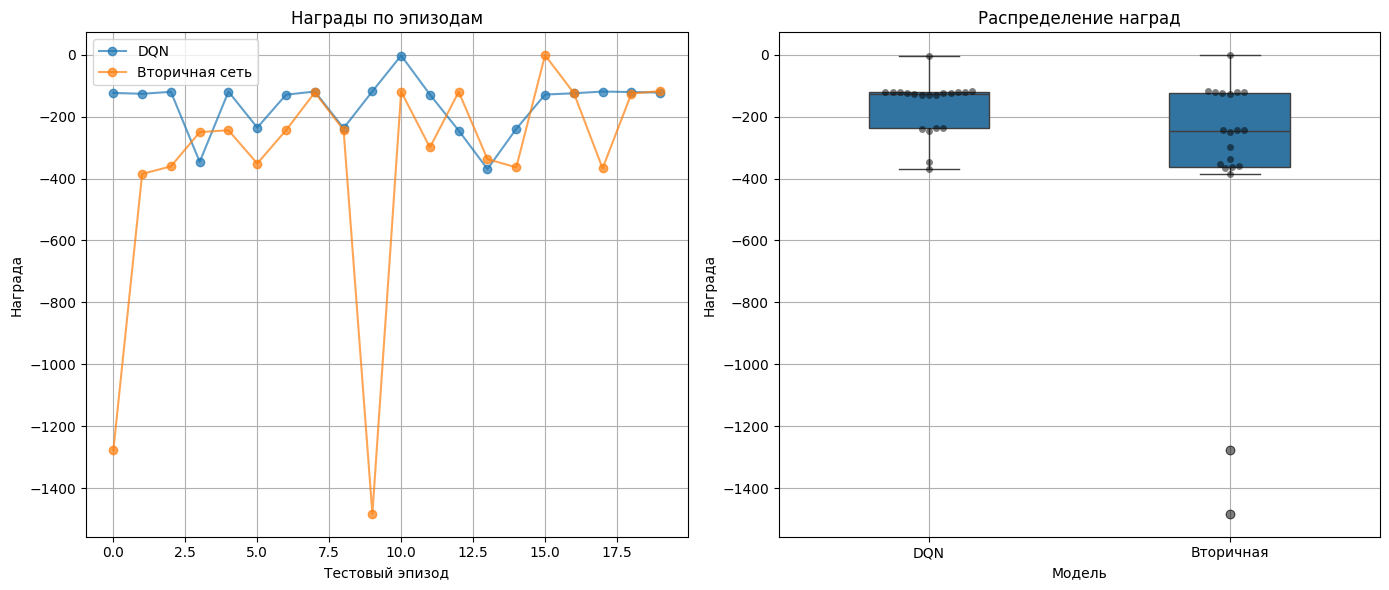

In [ ]:
import pandas as pd
# Вместо простого boxplot
plt.figure(figsize=(14, 6))

# График траекторий наград
plt.subplot(1, 2, 1)
plt.plot(dqn_rewards, 'o-', label='DQN', alpha=0.7)
plt.plot(secondary_rewards, 'o-', label='Вторичная сеть', alpha=0.7)
plt.title('Награды по эпизодам')
plt.xlabel('Тестовый эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True)

# Улучшенный boxplot с swarmplot
plt.subplot(1, 2, 2)
import seaborn as sns
data = pd.DataFrame({
    'Награда': dqn_rewards + secondary_rewards,
    'Модель': ['DQN']*len(dqn_rewards) + ['Вторичная']*len(secondary_rewards)
})
sns.boxplot(x='Модель', y='Награда', data=data, width=0.4)
sns.swarmplot(x='Модель', y='Награда', data=data, color='black', alpha=0.5)
plt.title('Распределение наград')
plt.grid(True)

plt.tight_layout()
plt.savefig('improved_model_comparison.png')
plt.show()

ValueError: RGBA values should be within 0-1 range

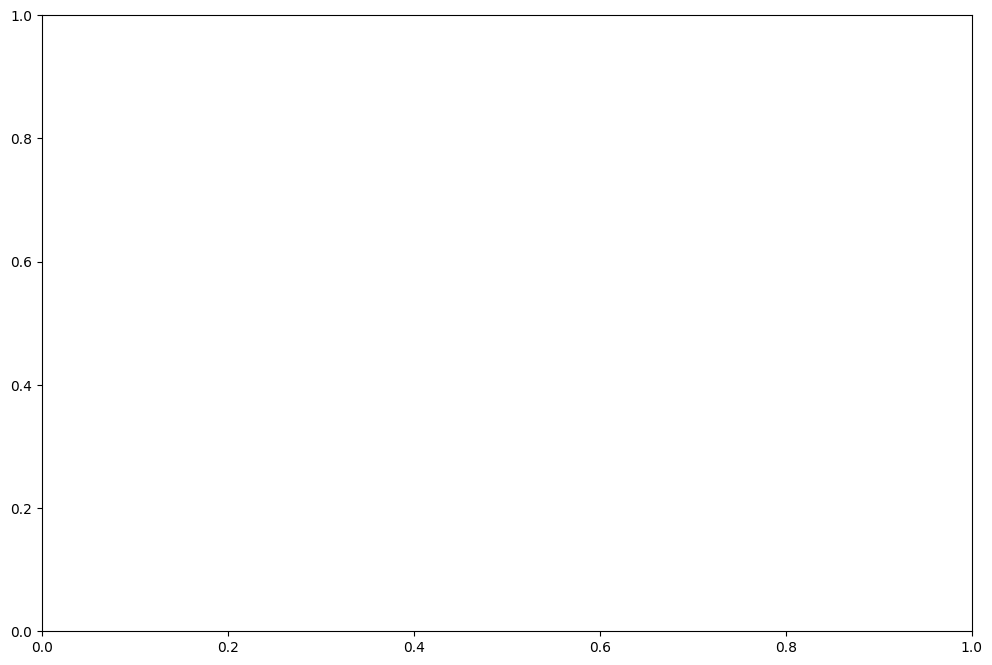

In [ ]:
from sklearn.manifold import TSNE

# Выберем подмножество данных для t-SNE (для скорости)
sample_idx = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx]

# Выполним t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Визуализация
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Действие')
plt.title('t-SNE визуализация скрытых представлений\n(цвет = выбранное действие)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne_visualization.png')
plt.show()

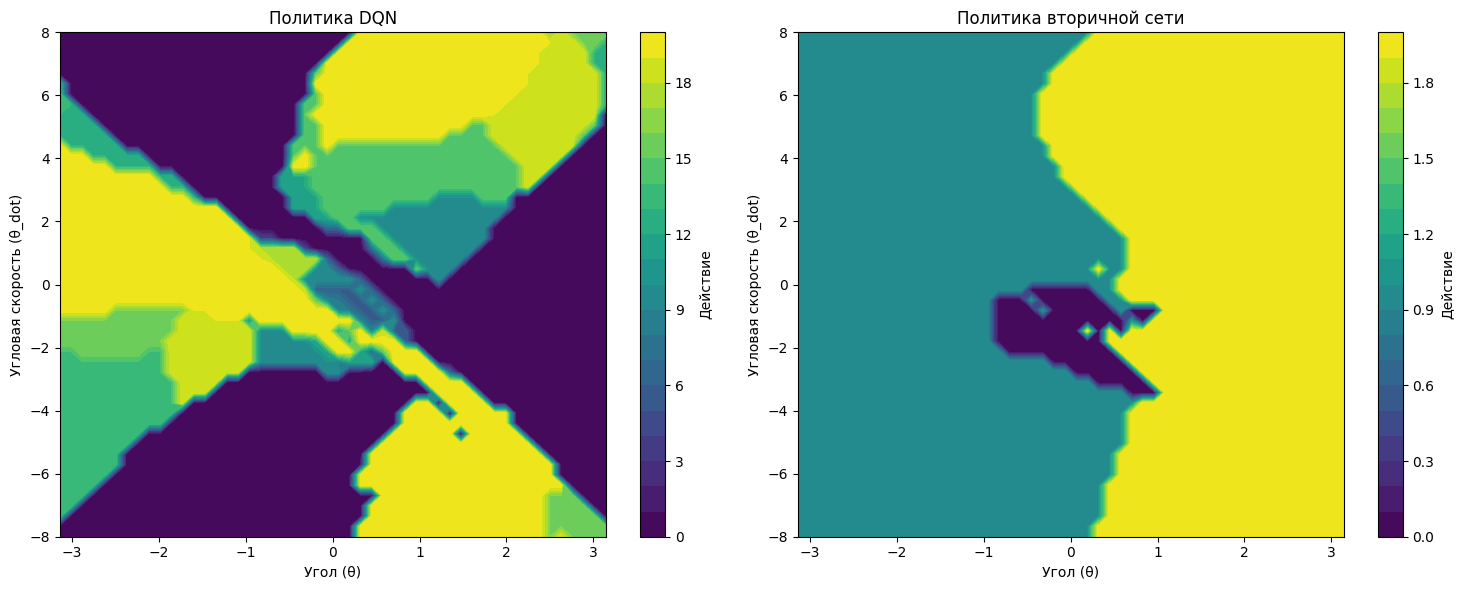

In [ ]:
# Генерация сетки состояний
theta = np.linspace(-np.pi, np.pi, 50)
theta_dot = np.linspace(-8, 8, 50)
states = np.array([[np.cos(t), np.sin(t), td] for t in theta for td in theta_dot])

# Предсказание действий
policy_net.eval()
secondary_net.eval()

with torch.no_grad():
    states_tensor = torch.tensor(states, device=device, dtype=torch.float32)

    # DQN политика
    q_values, _ = policy_net(states_tensor)
    dqn_actions = q_values.argmax(1).cpu().numpy()

    # Вторичная политика
    hidden_rep = policy_net.get_hidden_representation(states_tensor)
    secondary_actions = secondary_net(hidden_rep).argmax(1).cpu().numpy()

# Визуализация
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.contourf(theta, theta_dot, dqn_actions.reshape(50, 50), levels=action_size, cmap='viridis')
plt.colorbar(label='Действие')
plt.title('Политика DQN')
plt.xlabel('Угол (θ)')
plt.ylabel('Угловая скорость (θ_dot)')

plt.subplot(1, 2, 2)
plt.contourf(theta, theta_dot, secondary_actions.reshape(50, 50), levels=action_size, cmap='viridis')
plt.colorbar(label='Действие')
plt.title('Политика вторичной сети')
plt.xlabel('Угол (θ)')
plt.ylabel('Угловая скорость (θ_dot)')

plt.tight_layout()
plt.savefig('policy_comparison.png')
plt.show()

In [ ]:
# Вычисление дополнительных метрик
def analyze_rewards(rewards, name):
    print(f"\nАнализ {name}:")
    print(f"  Медиана: {np.median(rewards):.2f}")
    print(f"  Максимум: {np.max(rewards):.2f}")
    print(f"  Минимум: {np.min(rewards):.2f}")
    print(f"  Стандартное отклонение: {np.std(rewards):.2f}")
    print(f"  Процент успешных эпизодов (награда > -200): {100*np.mean(np.array(rewards) > -200):.1f}%")

analyze_rewards(dqn_rewards, "DQN")
analyze_rewards(secondary_rewards, "Вторичной сети")

# Разница в наградах
diff = np.array(dqn_rewards) - np.array(secondary_rewards)
print(f"\nВторичная сеть лучше DQN в {100*np.mean(diff < 0):.1f}% тестовых эпизодов")
print(f"Средняя разница в наградах: {np.mean(diff):.2f} ± {np.std(diff):.2f}")


Анализ DQN:
  Медиана: -125.48
  Максимум: -2.68
  Минимум: -369.17
  Стандартное отклонение: 85.46
  Процент успешных эпизодов (награда > -200): 70.0%

Анализ Вторичной сети:
  Медиана: -246.96
  Максимум: -1.84
  Минимум: -1482.64
  Стандартное отклонение: 362.38
  Процент успешных эпизодов (награда > -200): 35.0%

Вторичная сеть лучше DQN в 30.0% тестовых эпизодов
Средняя разница в наградах: 183.02 ± 377.60
